Epoch 0, D_loss: -0.0196198932826519, G_loss: -0.002812915714457631
Epoch 1000, D_loss: -0.5676397681236267, G_loss: -0.0747116282582283
Epoch 2000, D_loss: -0.5834974050521851, G_loss: -0.0628146156668663
Epoch 3000, D_loss: -0.5840404629707336, G_loss: -0.0533713698387146
Epoch 4000, D_loss: -0.5694400072097778, G_loss: -0.055190905928611755


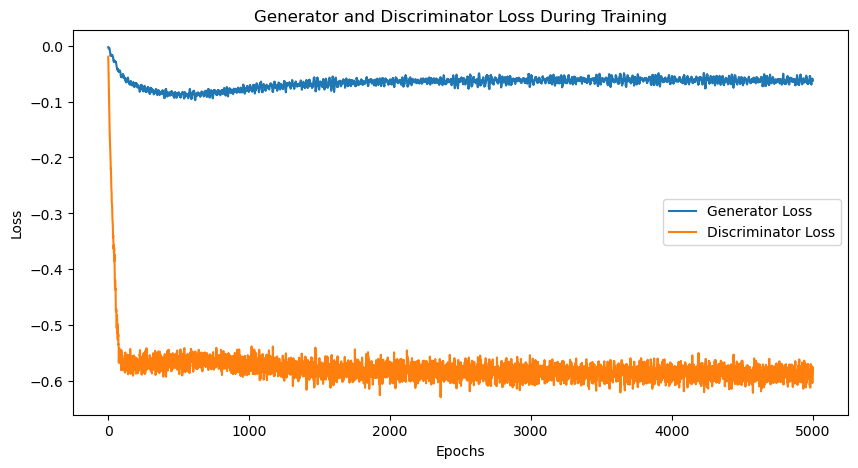

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=784):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, output_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim=784):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.main(x)

G = Generator()
D = Discriminator()

G_optimizer = optim.RMSprop(G.parameters(), lr=0.00005)
D_optimizer = optim.RMSprop(D.parameters(), lr=0.00005)

num_epochs = 5000
n_critic = 5

D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for _ in range(n_critic):
        real_data = Variable(torch.randn(64, 784))
        D_real = D(real_data)
        D_real_loss = -torch.mean(D_real)

        noise = Variable(torch.randn(64, 100))
        fake_data = G(noise).detach()
        D_fake = D(fake_data)
        D_fake_loss = torch.mean(D_fake)

        D_loss = D_real_loss + D_fake_loss

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

    noise = Variable(torch.randn(64, 100))
    fake_data = G(noise)
    G_loss = -torch.mean(D(fake_data))

    G_optimizer.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, D_loss: {D_loss.item()}, G_loss: {G_loss.item()}')

# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


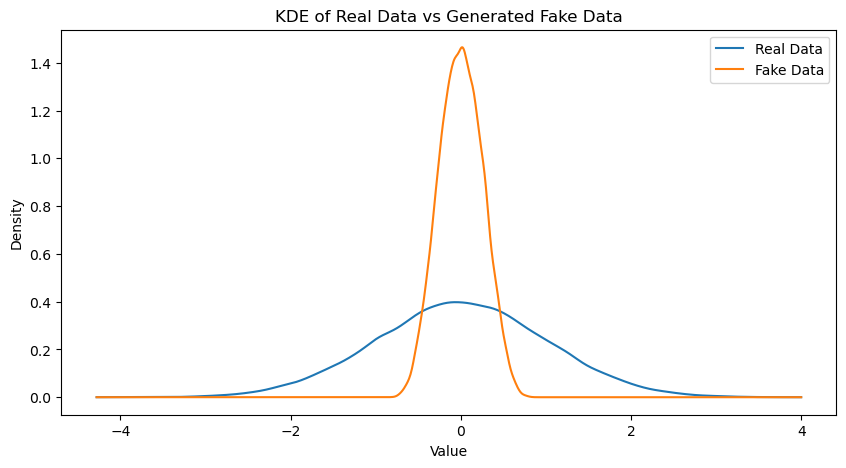

Integral of Real KDE: 1.0000
Integral of Fake KDE: 1.0000


In [5]:
# now plot the distribution of real data vs generated fake data (ie G(new_noise), where new_noise is newly sampled from the latent distribution)

import numpy as np
from scipy.stats import gaussian_kde

# Sample real data
real_sample = Variable(torch.randn(64, 784)).detach().numpy().flatten()

# Generate fake data using a new noise sample
new_noise = Variable(torch.randn(64, 100))
fake_sample = G(new_noise).detach().numpy().flatten()

# Fit KDE to real and fake data
real_kde = gaussian_kde(real_sample)
fake_kde = gaussian_kde(fake_sample)

# Create a range of x values for plotting
x_range = np.linspace(min(np.min(real_sample), np.min(fake_sample)),
                      max(np.max(real_sample), np.max(fake_sample)),
                      1000)

# Calculate KDE values
real_kde_values = real_kde(x_range)
fake_kde_values = fake_kde(x_range)

# Plot the KDE distributions
plt.figure(figsize=(10, 5))
plt.plot(x_range, real_kde_values, label='Real Data')
plt.plot(x_range, fake_kde_values, label='Fake Data')
plt.title("KDE of Real Data vs Generated Fake Data")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Verify that both distributions integrate to approximately 1
print(f"Integral of Real KDE: {np.trapz(real_kde_values, x_range):.4f}")
print(f"Integral of Fake KDE: {np.trapz(fake_kde_values, x_range):.4f}")



# ### Understanding the WGAN Implementation Above

The provided code implements a **Wasserstein Generative Adversarial Network (WGAN)**, a variant of the traditional GAN that uses the Wasserstein distance to improve training stability and performance. Here's a breakdown of its components and workflow:

1. **Generator (`G`) and Discriminator (`D`) Initialization**:
    - **Generator (`G`)**: Takes random noise as input and generates synthetic data resembling the real data distribution.
    - **Discriminator (`D`)**: Also referred to as the "critic" in WGANs, it evaluates the quality of the data by assigning a score rather than a probability.

2. **Optimizers**:
    - Both the generator and discriminator use the **RMSprop optimizer** with a learning rate of `0.00005`, suitable for the WGAN training process.

3. **Training Parameters**:
    - **`num_epochs = 10000`**: The model will train for 10,000 epochs.
    - **`n_critic = 5`**: For each generator update, the discriminator is updated five times. This helps in maintaining a balance between the generator and discriminator's learning rates.

4. **Training Loop**:
    - **Discriminator Updates**:
        - **Real Data**: Sampled from a normal distribution and passed through the discriminator to obtain `D_real`.
        - **Fake Data**: Generated by the generator using random noise and then passed through the discriminator to obtain `D_fake`.
        - **Loss Calculation**:
            - **`D_real_loss`**: Negative mean of `D_real`, encouraging the discriminator to assign high scores to real data.
            - **`D_fake_loss`**: Mean of `D_fake`, encouraging the discriminator to assign low scores to fake data.
            - **`D_loss`**: Sum of `D_real_loss` and `D_fake_loss`.
        - **Backpropagation**: Compute gradients and update discriminator weights.
        - **Weight Clipping**: Ensures the discriminator's weights remain within `[-0.01, 0.01]` to enforce Lipschitz continuity, a crucial condition for WGANs.
    
    - **Generator Updates**:
        - Generates fake data and evaluates it using the discriminator.
        - **`G_loss`**: Negative mean of the discriminator's output on fake data, encouraging the generator to produce data that the discriminator rates highly.
        - **Backpropagation**: Compute gradients and update generator weights.

5. **Logging**:
    - Every 1,000 epochs, the current losses of both the discriminator and generator are printed, allowing monitoring of the training progress.

This WGAN setup leverages the Wasserstein distance to provide more meaningful gradients, leading to improved convergence behavior compared to traditional GANs. The clipping of discriminator weights and the ratio of discriminator to generator updates are key components that contribute to the stability of the training process.
